## Introdução

Este projeto tem como objetivo desenvolver um modelo preditivo de sentimentos com base em dados de tweets. Com isso, através da aplicação de técnicas de aprendizado de máquina e processamento de linguagem natural, podemos extrair informações valiosas sobre as opiniões e emoções presentes nos _tweets_.

O conjunto de dados utilizado neste projeto consiste em uma coleção de _tweets_ rotulados com categorias relativamente bem abrangentes de sentimentos. O objetivo é construir um modelo capaz de analisar novos tweets e prever corretamente a categoria de sentimento associada a eles.

Neste projeto, iremos explorar o conjunto de dados de tweets, realizar análises exploratórias para compreender a distribuição dos sentimentos, identificar padrões e características relevantes nos textos. Em seguida, iremos treinar e avaliar diferentes modelos de aprendizado de máquina para classificação de sentimentos, com o objetivo de obter previsões precisas e confiáveis.

Ao final deste projeto, esperamos obter um modelo capaz de lidar com novos dados de tweets e prever corretamente os sentimentos expressos pelos usuários.

In [1]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt

DATASET_PATH = 'data/tweet_emotions.csv'

## Análise Exploratória dos Dados



In [9]:
filename = pathlib.Path.cwd() / DATASET_PATH

# leitura do dataset 
df = pd.read_csv(filename)

O dataset não contém valores nulos.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [10]:
# contagem de ocorrências por categoria de sentimento
ocorrencias = df['sentiment'].value_counts()

print(ocorrencias)

sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64


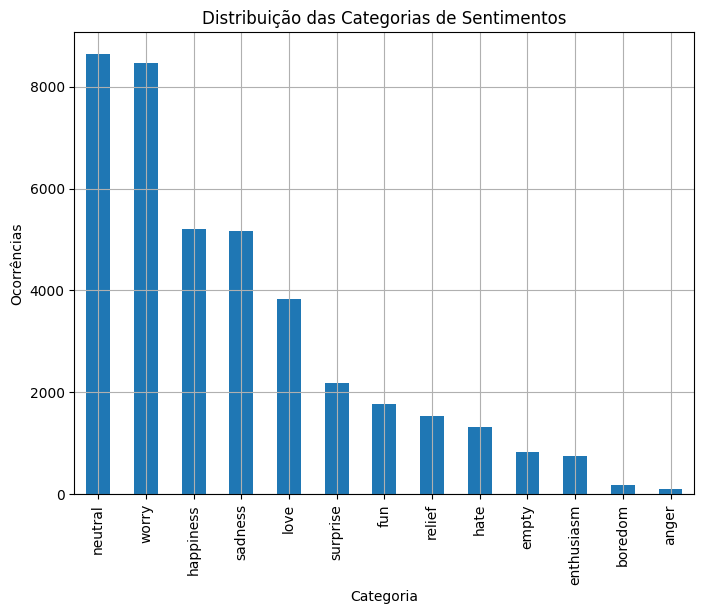

In [11]:
# Visualização da distribuição das categorias de sentimentos
plt.figure(figsize=(8, 6))

ocorrencias.plot(kind='bar')

plt.xlabel('Categoria')
plt.ylabel('Ocorrências')
plt.grid()
plt.title('Distribuição das Categorias de Sentimentos')
plt.show()

Como podemos observar, há uma grande discrepância nas ocorrências das diferentes categorias de sentimentos. Algumas categorias possuem um número significativamente maior de exemplos, enquanto outras estão sub-representadas. Essa discrepância poderia afetar a capacidade do modelo de generalizar adequadamente.


Com o objetivo de alcançar um conjunto de dados mais equilibrado, onde todas as classes tivessem uma representação mais semelhante, podemos reduzir o número de classes agrupando e renomendo elas. Essa abordagem pode permitir evitar um possível viés em direção às classes majoritárias.

Para simplificar, podemos agrupar as categorias em cinco classes gerais: **super positive**, **positive**, **neutral**, **negative** e **super negative**. Essas classes representam intervalos mais amplos de sentimentos em relação às originais.

In [12]:
df['sentiment'] = df['sentiment'].replace(['happiness', 'love'], 'super positive')
df['sentiment'] = df['sentiment'].replace(['fun', 'surprise', 'relief', 'enthusiasm'], 'positive')
df['sentiment'] = df['sentiment'].replace(['hate', 'sadness', 'anger'], 'super negative')
df['sentiment'] = df['sentiment'].replace(['worry', 'boredom', 'empty'], 'negative')

In [14]:
df['sentiment'].value_counts()

sentiment
negative          9465
super positive    9051
neutral           8638
super negative    6598
positive          6248
Name: count, dtype: int64

Após a aplicação do agrupamento das categorias de sentimentos, obtivemos uma distribuição mais equilibrada entre as classes. Agora, as ocorrências estão mais uniformemente distribuídas, o que é vantajoso para o treinamento e a avaliação dos modelos.

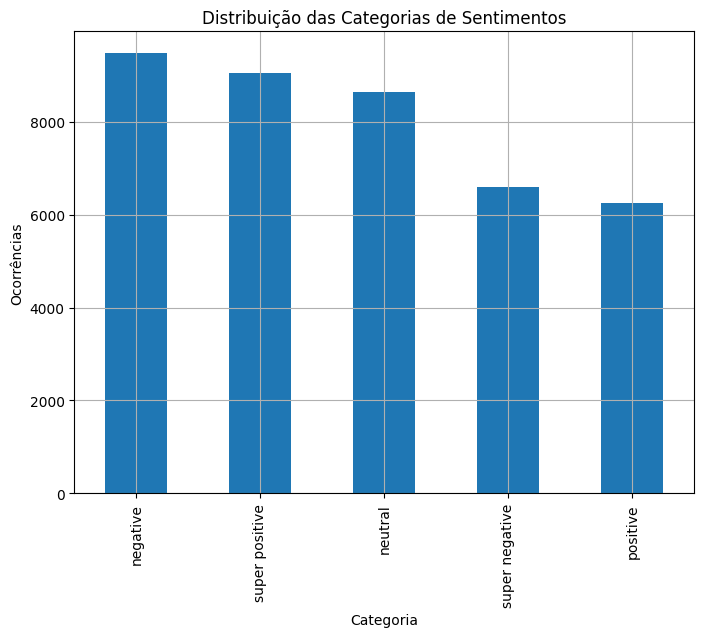

In [13]:
# Visualização da nova distribuição das categorias de sentimentos
plt.figure(figsize=(8, 6))

df['sentiment'].value_counts().plot(kind='bar')

plt.xlabel('Categoria')
plt.ylabel('Ocorrências')
plt.grid()
plt.title('Distribuição das Categorias de Sentimentos')
plt.show()

### Pré-processamento

In [31]:
import nltk

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [39]:
list(df.head()['content'])

['@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[',
 'Layin n bed with a headache  ughhhh...waitin on your call...',
 'Funeral ceremony...gloomy friday...',
 'wants to hang out with friends SOON!',
 '@dannycastillo We want to trade with someone who has Houston tickets, but no one will.']

In [32]:
# importação das bibliotecas necessárias para processamento
import string

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer



Nessa etapa de processamento do texto podemos aplicar algumas transformações para preparar cada linha do dataset para a análise posterior.

Para isso, podemos definir a função abaxio que realiza a seguinte sequência de transformações:

- **Remoção de pontuação e caracteres especiais**: nesta etapa, todas as pontuações e caracteres especiais são removidos do texto.

- **Conversão para letras minúsculas**: O texto é convertido para letras minúsculas. Isso é importante para garantir a consistência na comparação de palavras.

- **Tokenização**: O texto é dividido em palavras individuais, conhecidas como tokens.

- **Remoção de stopwords**: As stopwords são palavras comuns que geralmente não têm um significado importante para a análise de sentimentos, como artigos, preposições e pronomes. Nesta etapa, as stopwords são removidas do texto usando a biblioteca NLTK e a lista de stopwords em inglês.

- **Lematização**: A lematização é o processo de normalização de palavras à sua forma base. O lema de uma palavra é sua forma fundamental, independente de flexão ou conjugação.

- **Junção dos tokens**: Os tokens processados são novamente juntados em um único texto usando o espaço em branco como separador. Isso resulta no texto pré-processado final, que será usado para a análise de sentimentos.

Essas etapas de processamento são aplicadas a cada tweet do dataset.

In [34]:
# Remoção de pontuação e caracteres especiais
def preprocess_text(line: str):
    # Converter para letras minúsculas
    line = line.lower()
    
    # Remover pontuações
    line = line.translate(str.maketrans("", "", string.punctuation))
    
    # Tokenização
    tokens = line.split()

    # Remover stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lematização
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Juntar tokens novamente em um único texto
    processed_text = " ".join(tokens)
    
    return processed_text

Aqui podemos inspecionar resultado do processamento de algumas linhas do dataset: 

In [35]:
samples = df['content'].sample(5, random_state=42)

for sample in samples:
    print('before:', sample)
    print('after:', preprocess_text(sample))
    print()

before: Good Morning
after: good morning

before: I just put my computer up on craigslist. I've had the same case, monitor, and speakers for over 5 years.
after: put computer craigslist ive case monitor speaker 5 year

before: in ten minutes shopping   demi lovato-back around demi lovato-behind enemy lines have you all seen the titanic 2 trailer? its really good!
after: ten minute shopping demi lovatoback around demi lovatobehind enemy line seen titanic 2 trailer really good

before: From twitterberry moved to ubertwitter - suffered from BB cache errors
after: twitterberry moved ubertwitter suffered bb cache error

before: @thriftymom TEAR*
after: thriftymom tear



### Pipeline de processamento

In [47]:
# importação das bibliotecas relacionadas aos modelos do Scikit-Learn
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.compose import ColumnTransformer

### Separação em treinamento e teste

In [41]:
CATEGORICAL_COL = "sentiment"

X = df.drop([CATEGORICAL_COL, 'tweet_id'], axis=1)
y = df[CATEGORICAL_COL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [42]:
print("X train shape:", X_train.shape)
print("y train shape:", y_train.shape)
print("X test shape:", X_test.shape)
print("y test shape:", y_test.shape)

X train shape: (32000, 1)
y train shape: (32000,)
X test shape: (8000, 1)
y test shape: (8000,)


A pipeline realiza a remoção de pontuações, conversão para letras minúsculas, remoção de stopwords, tokenização e lematização do texto. Em seguida, é aplicada a vetorização usando o `CountVectorizer` e a transformação TF-IDF com o `TfidfTransformer`.

O `TfidfTransformer` é usado para transformar os valores numéricos resultantes da contagem de palavras em um vetor ponderado usando a medida TF-IDF (Term Frequency-Inverse Document Frequency). O TF-IDF costuma ser utilizado para avaliar a importância de uma palavra em um texto.

In [48]:
def create_model(model):
    # Criar a pipeline de pré-processamento 
    preprocessor = ColumnTransformer(
        transformers=[
            ('text_preprocessing', Pipeline([
                ('count_vectorizer', CountVectorizer(preprocessor=preprocess_text)),
                ('tfidf_transformer', TfidfTransformer())
            ]), 'content'),
        ],
        remainder='passthrough',
        verbose=True
    )

    # Aplicar a pipeline aos dados
    return Pipeline([
            ('preprocessing', preprocessor),
            ('model', model)  
        ], verbose=True)

### Modelos

Para a análise, vamos utilizar 3 modelos: **Regressão Logística**, **Random Forest** e **Classificador Naive Bayes**.

In [53]:
logistic_model = create_model(LogisticRegression(max_iter=1000))
logistic_model.fit(X_train, y_train)

[ColumnTransformer]  (1 of 1) Processing text_preprocessing, total=  16.6s
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=  16.6s
[Pipeline] ............. (step 2 of 2) Processing model, total=  13.7s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text_preprocessing',
                                                  Pipeline(steps=[('count_vectorizer',
                                                                   CountVectorizer(preprocessor=<function preprocess_text at 0x000001FD514D0180>)),
                                                                  ('tfidf_transformer',
                                                                   TfidfTransformer())]),
                                                  'content')],
                                   verbose=True)),
                ('model', LogisticRegression(max_iter=1000))],
         verbose=True)

In [54]:
random_forest_model = create_model(RandomForestClassifier(n_estimators=100, max_features="sqrt", max_depth=60, min_samples_split=3))
random_forest_model.fit(X_train, y_train)

[ColumnTransformer]  (1 of 1) Processing text_preprocessing, total=  19.6s
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=  19.6s
[Pipeline] ............. (step 2 of 2) Processing model, total= 1.6min


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text_preprocessing',
                                                  Pipeline(steps=[('count_vectorizer',
                                                                   CountVectorizer(preprocessor=<function preprocess_text at 0x000001FD514D0180>)),
                                                                  ('tfidf_transformer',
                                                                   TfidfTransformer())]),
                                                  'content')],
                                   verbose=True)),
                ('model',
                 RandomForestClassifier(max_depth=60, min_samples_split=3))],
         verbose=True)

In [55]:
naive_bayes_model = create_model(MultinomialNB(alpha=1e-7, fit_prior=True))
naive_bayes_model.fit(X_train, y_train)

[ColumnTransformer]  (1 of 1) Processing text_preprocessing, total=  21.5s
[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=  21.5s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.1s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('text_preprocessing',
                                                  Pipeline(steps=[('count_vectorizer',
                                                                   CountVectorizer(preprocessor=<function preprocess_text at 0x000001FD514D0180>)),
                                                                  ('tfidf_transformer',
                                                                   TfidfTransformer())]),
                                                  'content')],
                                   verbose=True)),
                ('model', MultinomialNB(alpha=1e-07))],
         verbose=True)

### Cálculo de score

Para comparar os modelos, vamos realizar predições no mesmo conjunto de dados de teste utilizando cada um deles e calcular os seguintes scores relevantes para fins de comparação:

`accuracy`: A acurácia mede a proporção de predições corretas em relação ao total de amostras. É uma métrica amplamente utilizada, **especialmente quando as classes estão equilibradas**.

`precision`: A precisão é a proporção de verdadeiros positivos em relação ao total de amostras previstas como positivas. Ela mede a capacidade do modelo em evitar falsos positivos. Uma alta precisão indica que a maioria das predições positivas do modelo é correta.

`recall`: O recall é a proporção de verdadeiros positivos em relação ao total de amostras reais positivas. Ele mede a capacidade do modelo em identificar corretamente os exemplos positivos. Um alto recall indica que o modelo consegue encontrar a maioria dos exemplos positivos.

`f1-score`: O F1-Score é uma medida que combina precisão e recall em uma única métrica. É a média harmônica entre precisão e recall, fornecendo uma medida balanceada do desempenho do modelo. O F1-Score é especialmente útil quando as classes estão desbalanceadas, pois leva em consideração tanto os falsos positivos quanto os falsos negativos.

In [ ]:
from sklearn import metrics

def calculate_score(model):
    # realiza predição nos dados de teste
    y_pred = model.predict(X_test)

    # calcular a acurácia
    accuracy = metrics.accuracy_score(y_test, y_pred)

    # calcular precisão, recall e F1-score
    precision = metrics.precision_score(y_test, y_pred, average='weighted')
    recall = metrics.recall_score(y_test, y_pred, average='weighted')
    f1_score = metrics.f1_score(y_test, y_pred, average='weighted')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1_score)

In [56]:
calculate_score(logistic_model)

Accuracy: 0.393875
Precision: 0.3797827548296669
Recall: 0.393875
F1-score: 0.3805625479095133


In [57]:
calculate_score(random_forest_model)

Accuracy: 0.396
Precision: 0.4344384614359159
Recall: 0.396
F1-score: 0.3446915260192358


In [58]:
calculate_score(naive_bayes_model)

Accuracy: 0.3325
Precision: 0.32007852166309125
Recall: 0.3325
F1-score: 0.3212975258457484
